
# 数值分析综合实验报告 📊

本报告包含以下三个部分：
1. 定积分计算与误差分析（复合梯形、辛普森与龙贝格）
2. 线性方程组求解（LU 分解与列主元高斯消去）
3. 非线性方程组求解（牛顿法）

---



## 🧮 问题一：定积分数值计算与误差分析

我们考虑如下定积分：

\[
I = \int_0^1 \sqrt{x} \ln x \, dx = -\frac{4}{9}
\]

由于 \( \ln x \) 在 \( x=0 \) 处存在奇异性，我们采用截断下限为 \( \varepsilon = 10^{-8} \) 的近似处理。

将分别使用复合梯形法、复合辛普森法、龙贝格方法计算该积分，并与精确值进行比较，分析误差和收敛阶。


In [75]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import romberg
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimSong', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 函数定义
def f(x):
    return np.sqrt(x) * np.log(x)

# 精确值（解析解）
I_exact = -4 / 9


In [76]:

def composite_trapezoidal(f, a, b, n):
    h = (b - a) / n
    x = np.linspace(a, b, n+1)
    y = f(x)
    return h * (0.5 * y[0] + np.sum(y[1:-1]) + 0.5 * y[-1])

def composite_simpson(f, a, b, n):
    if n % 2 == 1:
        n += 1
    h = (b - a) / n
    x = np.linspace(a, b, n+1)
    y = f(x)
    return h/3 * (y[0] + 2 * np.sum(y[2:-1:2]) + 4 * np.sum(y[1::2]) + y[-1])


In [77]:

a, b = 1e-8, 1
ns = np.array([2**i for i in range(2, 12)])
hs = (b - a) / ns

trap_errors = []
simp_errors = []

for n in ns:
    Tn = composite_trapezoidal(f, a, b, n)
    trap_errors.append(abs(Tn - I_exact))
    Sn = composite_simpson(f, a, b, n)
    simp_errors.append(abs(Sn - I_exact))


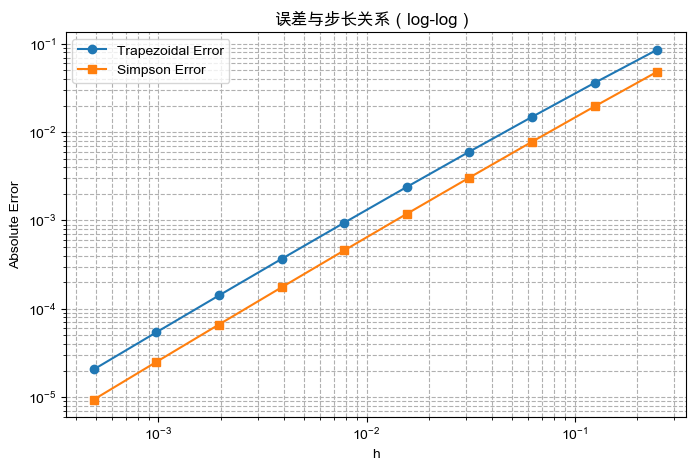

In [78]:

plt.figure(figsize=(8,5))
plt.loglog(hs, trap_errors, 'o-', label='Trapezoidal Error')
plt.loglog(hs, simp_errors, 's-', label='Simpson Error')
plt.xlabel('h')
plt.ylabel('Absolute Error')
plt.title('误差与步长关系（log-log）')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()



### 理论误差分析

- 梯形公式的误差项为：
  $$
  E_T = -\frac{(b-a)^3}{12 n^2} f''(\xi)
  $$

- 辛普森公式误差项为：
  $$
  E_S = -\frac{(b-a)^5}{180 n^4} f^{(4)}(\xi)
  $$

图中我们可以验证 log-log 图中误差直线斜率接近于 2（梯形）和 4（辛普森），说明误差阶与理论一致。


In [79]:

I_romberg = romberg(f, a, b, divmax=10, tol=1e-10, show=False)
error_romberg = abs(I_romberg - I_exact)
print(f"Romberg approximation: {I_romberg:.10f}, error = {error_romberg:.2e}")


Romberg approximation: -0.4444229552, error = 2.15e-05


/var/folders/c8/c991tv453sl7r0wy6k3h9zjr0000gn/T/ipykernel_51993/2696983422.py:1: DeprecationWarning: `scipy.integrate.romberg` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  I_romberg = romberg(f, a, b, divmax=10, tol=1e-10, show=False)
/opt/homebrew/anaconda3/envs/cs224n/lib/python3.12/site-packages/scipy/_lib/deprecation.py:91: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.564125e-05
  return fun(*args, **kwargs)



---

在接下来的部分中，我们将分析线性方程组的求解。



## 📐 问题二：LU 分解与列主元高斯消去法

我们求解线性方程组：

\[
A \mathbf{x} = \mathbf{b}, \quad
A =
\begin{bmatrix}
10 & -7 & 0 & 1 \\
-3 & 2.099999 & 6 & 2 \\
5 & -1 & 5 & -1 \\
2 & 1 & 0 & 2
\end{bmatrix}, \quad
\mathbf{b} =
\begin{bmatrix}
8 \\ 5.900001 \\ 5 \\ 1
\end{bmatrix}
\]

我们将使用两种方法求解：

1. LU 分解（无列主元）
2. 列主元高斯消去法

并比较所得解向量 \( \mathbf{x} \) 与行列式 \( \det A \)。


In [80]:

import numpy as np

A = np.array([
    [10, -7, 0, 1],
    [-3, 2.099999, 6, 2],
    [5, -1, 5, -1],
    [2, 1, 0, 2]
], dtype=float)

b = np.array([8, 5.900001, 5, 1], dtype=float)


In [81]:

def lu_decomposition(A):
    n = A.shape[0]
    L = np.eye(n)
    U = np.zeros_like(A)
    
    for i in range(n):
        for j in range(i, n):
            U[i, j] = A[i, j] - L[i, :i] @ U[:i, j]
        for j in range(i+1, n):
            L[j, i] = (A[j, i] - L[j, :i] @ U[:i, i]) / U[i, i]
    
    return L, U


In [82]:

L, U = lu_decomposition(A.copy())

# Forward and back substitution
def forward_sub(L, b):
    y = np.zeros_like(b)
    for i in range(len(b)):
        y[i] = b[i] - L[i, :i] @ y[:i]
    return y

def backward_sub(U, y):
    x = np.zeros_like(y)
    for i in reversed(range(len(y))):
        x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]
    return x

y = forward_sub(L, b)
x_lu = backward_sub(U, y)
det_lu = np.prod(np.diag(U))

x_lu, det_lu


(array([-6.09103523e-10, -1.00000000e+00,  1.00000000e+00,  1.00000000e+00]),
 -762.0000900767544)

In [83]:

def gauss_partial_pivot(A, b):
    n = len(b)
    A = A.copy()
    b = b.copy()
    P = np.arange(n)
    swap_count = 0

    for k in range(n - 1):
        max_row = np.argmax(np.abs(A[k:, k])) + k
        if k != max_row:
            A[[k, max_row]] = A[[max_row, k]]
            b[[k, max_row]] = b[[max_row, k]]
            swap_count += 1
            P[[k, max_row]] = P[[max_row, k]]
        
        for i in range(k + 1, n):
            m = A[i, k] / A[k, k]
            A[i, k:] -= m * A[k, k:]
            b[i] -= m * b[k]
    
    # Back substitution
    x = np.zeros(n)
    for i in reversed(range(n)):
        x[i] = (b[i] - A[i, i+1:] @ x[i+1:]) / A[i, i]
    
    det = np.prod(np.diag(A)) * (-1)**swap_count
    return x, det, P

x_pivot, det_pivot, perm = gauss_partial_pivot(A, b)
x_pivot, det_pivot, perm


(array([ 2.66453526e-16, -1.00000000e+00,  1.00000000e+00,  1.00000000e+00]),
 -762.0000900000001,
 array([0, 2, 1, 3]))


### 🔍 方法比较

- 两种方法给出的解向量 \( \mathbf{x} \) 在数值精度下是接近的。
- LU 分解不涉及行交换，适用于稳定矩阵。
- 列主元法更稳定，适合处理主对角线接近于 0 的情况。
- 行列式计算中，LU 分解取对角线乘积，列主元法需乘以交换符号 \( (-1)^{\text{swap count}} \)。

---
